# import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import nltk
import networkx as nx

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
not_needed = ['AU', 'BA', 'BF', 'CA', 'GP', 'SO', 'ID', 'CT', 'PU', 'PY', 'BE', 'SE', 'BS', 'CY' ,'CL', 'SP', 'HO', 'RP', 'EM', 
              'RI', 'OI', 'FU', 'FX', 'CR', 'TC', 'U1', 'U2', 'PI', 'PA', 'SN', 'EI', 'BN', 'J9', 
              'VL', 'IS', 'SI', 'PN', 'SU', 'MA', 'BP', 'EP', 'AR', 'DI', 'D2', 'EA', 'GA', 'PM', 'UT', 
              'OA', 'HP', 'HC', 'DA', 'WC'] 

def to_df(directory, not_needed=not_needed):
    file_names = os.listdir(directory)
    data_frames = [pd.read_csv(directory+file_name, sep='\t',  engine='c', index_col=False, quotechar='^') for file_name in file_names] 
    print('Checking duplicates...')
    all_clear = True
    for i in range(len(data_frames)):
        for j in range(i+1, len(data_frames)):
            if str(data_frames[i].iloc[0,:]) == str(data_frames[j].iloc[0,:]):
                print('Duplicated dataframes:' + str(file_names[i]) +', '+str(file_names[j]))
                all_clear = False
    if all_clear:
        print('All clear')
    else:
        print('Check the files')
        
    concatenated = pd.concat(data_frames, ignore_index=True)
    if not_needed:
        concatenated.drop(columns=not_needed, inplace=True)
    concatenated.drop_duplicates(inplace=True)
    return concatenated

In [4]:
data = to_df('/content/drive/MyDrive/data/')

Checking duplicates...
All clear


In [5]:
data.to_excel("/content/drive/MyDrive/data.xlsx")


In [6]:
data = pd.read_excel('/content/drive/MyDrive/data.xlsx')

In [7]:
mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data.PD = data.PD.str[:3].str.capitalize()
data_w_date = data[data.PD.isin(mon)].copy()
data_w_date.PD = data_w_date.PD.apply(lambda x: datetime.strptime(x,'%b').strftime('2020-%m'))

In [8]:
len(data_w_date)

69192

In [9]:
len(data)

82892

# Document type

In [10]:
data.PT.dropna().value_counts()

J    82888
S        3
B        1
Name: PT, dtype: int64

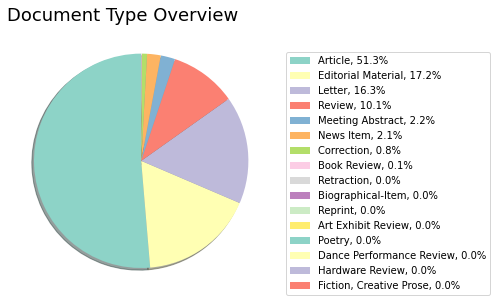

In [11]:
data_doc = data.DT.dropna().str.split(';').apply(lambda x: x[0]).value_counts().rename_axis('DocType').reset_index(name='Count')

with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
    fig1, ax1 = plt.subplots(figsize=(7, 7))
    labels = data_doc.iloc[:,0]
    size = data_doc.iloc[:,1]/data_doc.iloc[:,1].sum()*100
    ax1.pie(data_doc.iloc[:,1], startangle=90, shadow=True)
    ax1.legend(labels =['%s, %1.1f%%' % (l,s) for l,s in zip(labels,size)], loc=(1.04,0))
    ax1.set_title('Document Type Overview', fontsize=18, loc='left')
    plt.tight_layout()

    plt.savefig('doc_type.jpg')
    plt.show()


In [12]:
len(data.DT.dropna().str.split(';').apply(lambda x: x[0]).value_counts())

16

# By language

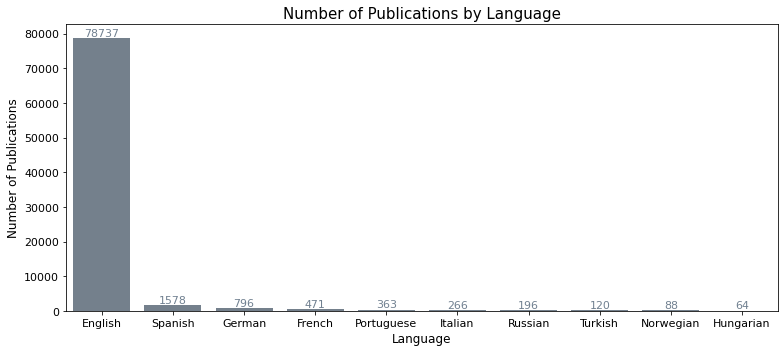

In [13]:
data_lang = data.LA.dropna().value_counts().rename_axis('Language').reset_index(name='Count')[0:10]

plt.figure(figsize=(11,5))
g = sns.barplot(x=data_lang.Language, y=data_lang.Count, color='slategrey')
plt.xlabel('Language',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')
plt.title('Number of Publications by Language', fontsize=15)
plt.tight_layout()
plt.savefig('doc_lang.jpg')
plt.show()

In [14]:
data.LA.dropna().value_counts()

English        78737
Spanish         1578
German           796
French           471
Portuguese       363
Italian          266
Russian          196
Turkish          120
Norwegian         88
Hungarian         64
Chinese           50
Polish            33
Czech             22
Icelandic         15
Croatian          14
Catalan           13
Slovenian         11
Ukrainian         11
Korean            10
Greek              9
Bulgarian          4
Unspecified        4
Dutch              3
Slovak             3
Indonesian         2
Lithuanian         2
Afrikaans          2
Japanese           2
Malay              1
Swedish            1
Arabic             1
Name: LA, dtype: int64

In [15]:
len(data.LA.dropna().value_counts())

31

# By source

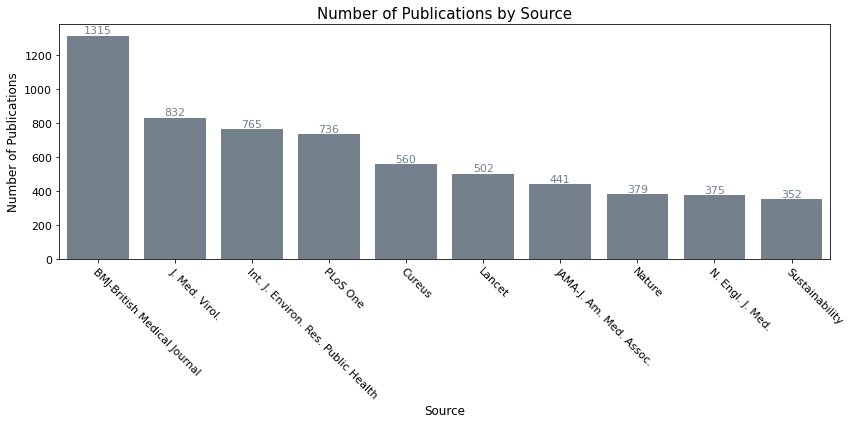

In [16]:
data_source = data.JI.dropna().value_counts().rename_axis('Title').reset_index(name='Count')[0:10]

plt.figure(figsize=(12,6))
g=sns.barplot(x=data_source.Title, y=data_source.Count, color='slategrey')
plt.xlabel('Source',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45, ha='left', rotation_mode='anchor')
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')
plt.title('Number of Publications by Source', fontsize=15)
plt.tight_layout()
plt.savefig('doc_source.jpg')
plt.show()

In [18]:
data.JI.dropna().value_counts()[:20]

BMJ-British Medical Journal            1315
J. Med. Virol.                          832
Int. J. Environ. Res. Public Health     765
PLoS One                                736
Cureus                                  560
Lancet                                  502
JAMA-J. Am. Med. Assoc.                 441
Nature                                  379
N. Engl. J. Med.                        375
Sustainability                          352
Int. J. Infect. Dis.                    332
Front. Public Health                    322
Front. Med.                             299
Front. Psychol.                         297
Crit. Care                              297
J. Med. Internet Res.                   295
Dermatol. Ther.                         290
Med. Hypotheses                         288
J. Clin. Med.                           278
J. Infect.                              276
Name: JI, dtype: int64

In [19]:
len(data.JI.dropna().value_counts())

7501

# Number of pages


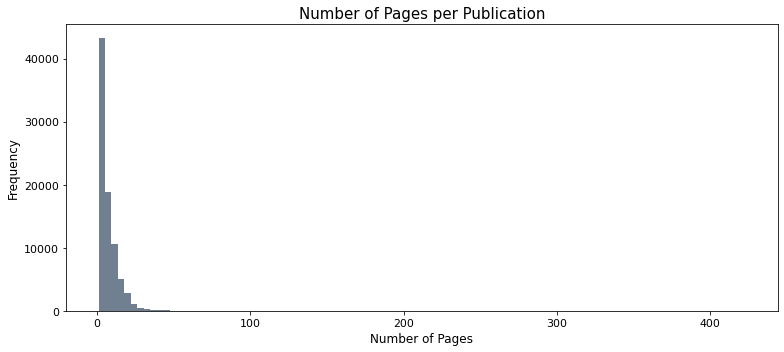

In [21]:
data_page = data.PG.dropna()

plt.figure(figsize=(11,5))
plt.hist(x=data_page, color='slategrey', bins=100)
plt.xlabel('Number of Pages',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Number of Pages per Publication', fontsize=15)
plt.tight_layout()
plt.savefig('doc_page.jpg')
plt.show()

In [22]:
min(data_page)

1

In [23]:
sorted(data_page)[-5:]

[161, 172, 293, 310, 423]

In [24]:
np.mean(data_page)

6.990553973845485

In [25]:
np.median(data_page)

5.0

# By institution

In [26]:
data_inst = data[['C1']].dropna()
data_inst.C1= data_inst.C1.apply(lambda x: re.findall(r"\] (.*?)\,", x))


In [27]:
data_inst['unik_inst'] = data_inst.C1.apply(lambda x: list(set(x)))
data_inst_all = data_inst.explode('unik_inst')['unik_inst'].value_counts().rename_axis('Institutions').reset_index(name='Count')[0:10]


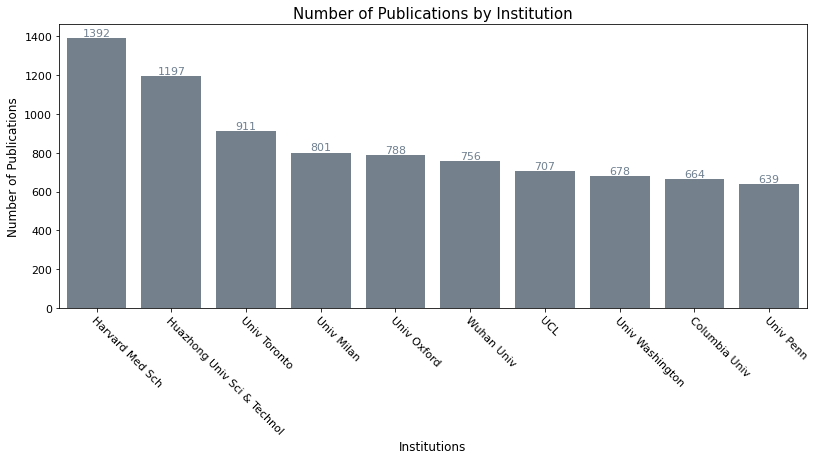

In [28]:


plt.figure(figsize=(11.5,6.5))
g=sns.barplot(x=data_inst_all.Institutions, y=data_inst_all.Count, color='slategrey')
plt.xlabel('Institutions',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45, ha='left', rotation_mode='anchor')
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')

plt.title('Number of Publications by Institution', fontsize=15)
plt.tight_layout()
plt.savefig('doc_inst.jpg')
plt.show()

In [29]:
data_inst.explode('C1').C1.value_counts()[:20]

Huazhong Univ Sci & Technol    2298
Harvard Med Sch                1842
Wuhan Univ                     1528
Univ Toronto                   1522
Univ Oxford                    1127
Univ Milan                     1121
Icahn Sch Med Mt Sinai         1079
Columbia Univ                  1073
Univ Penn                      1055
Univ Washington                1035
Univ Tehran Med Sci             985
Univ Calif San Francisco        957
Stanford Univ                   928
UCL                             918
Univ Michigan                   890
Univ Sao Paulo                  870
Mayo Clin                       866
Johns Hopkins Univ              798
Massachusetts Gen Hosp          789
Fudan Univ                      763
Name: C1, dtype: int64

In [30]:
len(data_inst.explode('C1').C1.value_counts())

52421

# By country

In [31]:
data_country = data[['C1']].dropna()
data_country.C1 = data_country.C1.apply(lambda x: re.sub(r"\[(.*?)\] ", "", x).split('; ')).to_list()

data_country['country']=[list(set(i)) for i in [[j.split(', ')[-1] for j in i] for i in data_country.C1]] 

def replace(string):
  if 'USA' in string:
    return 'USA'
  elif 'North Ireland' in string:
    return 'United Kingdom'
  elif 'Wales' in string:
    return 'United Kingdom'
  elif 'Scotland' in string:
    return 'United Kingdom'
  elif 'England' in string:
    return 'United Kingdom'
  elif 'P. R. China' in string:
    return 'China'
  elif 'Peoples R China' in string:
    return 'China'
  elif 'Viet Nam' in string:
    return 'Vietnam'
  else:
    return string
data_country['replace_1'] = [[replace(i) for i in j] for j in data_country['country']]
data_country['replace'] = [list(set(i)) for i in data_country['replace_1']]



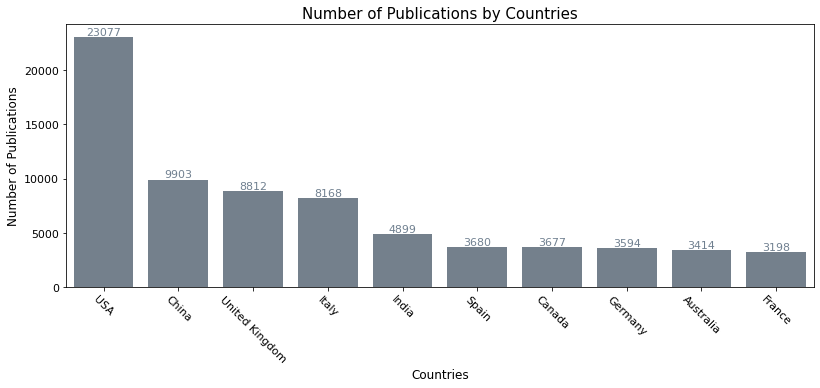

In [32]:
data_country_all = data_country.explode('replace')['replace'].value_counts().rename_axis('Countries').reset_index(name='Count')
data_country_10 = data_country_all[0:10]


plt.figure(figsize=(11.5,5.5))
g=sns.barplot(x=data_country_10.Countries, y=data_country_10.Count, color='slategrey')
plt.xlabel('Countries',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45)
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')

plt.title('Number of Publications by Countries', fontsize=15)
plt.tight_layout()
plt.savefig('doc_country.jpg')
plt.show()

In [33]:
sorted(data_country_all.Countries.unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua & Barbu',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'BELARUS',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia & Herceg',
 'Botswana',
 'Brazil',
 'British Virgin Isl',
 'Brunei',
 'Brunei Darussal',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Cent Afr Republ',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Costa Rica',
 'Cote Ivoire',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'DEM REP CONGO',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Rep',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Falkland Island',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 

In [34]:
len(data_country_all.Countries.unique())

201

# By research area

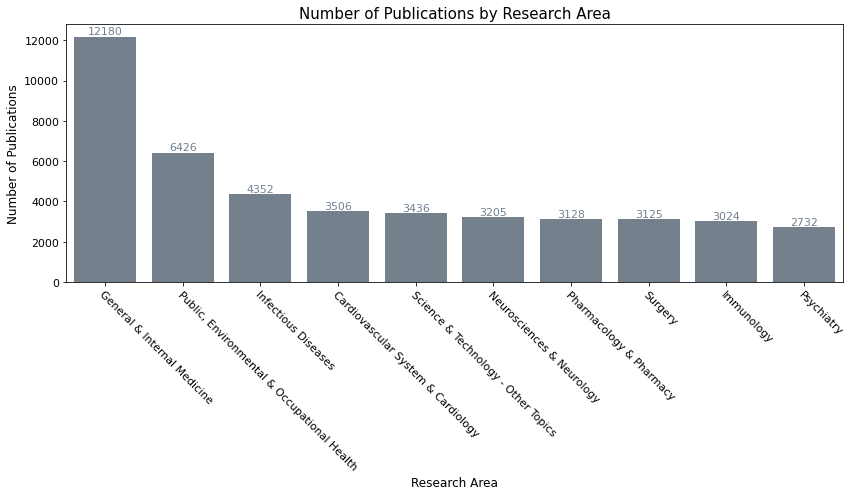

In [35]:
data_research = data[['SC']].dropna()
data_research.SC = data_research.SC.str.split('; ')
data_research_all = data_research.explode('SC').SC.value_counts().rename_axis('ResArea').reset_index(name='Count')[:10]

plt.figure(figsize=(12,7))
g=sns.barplot(x=data_research_all.ResArea, y=data_research_all.Count, color='slategrey')
plt.xlabel('Research Area',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45, ha='left', rotation_mode='anchor')
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')

plt.title('Number of Publications by Research Area', fontsize=15)
plt.tight_layout()
plt.savefig('doc_research.jpg')
plt.show()

In [36]:
len(data_research.explode('SC').SC.value_counts())

151

# By author keyword

In [37]:
data_keywords=data[['DE']].dropna()
data_keywords.DE = data_keywords.DE.str.split('; ')
data_keywords_full = data_keywords.explode('DE').DE.str.lower().value_counts().rename_axis('Author Keywords').reset_index(name='Count')
data_keywords_full.head(22)


,Author Keywords,Count
0,covid-19,29920
1,sars-cov-2,9442
2,coronavirus,6327
3,pandemic,4106
4,public health,1070
5,coronavirus disease 2019,988
6,mental health,959
7,epidemiology,828
8,covid-19 pandemic,818
9,telemedicine,806


In [38]:
len(data_keywords_full)

62565

# Author table

In [39]:
data_author = data[['AF']].dropna()
len(data_author.loc[data_author.AF == '[Anonymous]'])

874

In [40]:

data_author = data_author.loc[data_author.AF != '[Anonymous]']
data_author.AF = data_author.AF.str.split('; ')
data_author_all = data_author.explode('AF').AF.value_counts().rename_axis('AF').reset_index(name='Number of papers')

In [41]:
author_cited = data[['AF','Z9','SC']].dropna()
author_cited = author_cited.loc[author_cited.AF != '[Anonymous]']
author_cited.AF = author_cited.AF.str.split('; ')
author_cited_all = author_cited.explode('AF').sort_values('Z9', ascending=False).drop(columns = 'SC').reset_index().drop(columns = 'index')
author_cited_all = author_cited_all[['AF', 'Z9']]
au_ci = author_cited_all.groupby('AF').sum().sort_values('Z9', ascending=False)
au_ci_1 = author_cited_all.groupby('AF').count().reset_index().rename(columns={'Z9':'Count'})
au_ci_per = pd.merge(au_ci, au_ci_1, on='AF', how='inner')
au_ci_per['Number cited per paper'] = au_ci_per['Z9']/au_ci_per['Count']
au_ci_per = au_ci_per.drop(columns=['Z9', 'Count']).sort_values('Number cited per paper', ascending=False)

author_tb = pd.merge(data_author_all, au_ci, on='AF', how='inner').dropna()
author_tb['Cited per paper'] = author_tb.Z9/author_tb['Number of papers']
author_tb = author_tb[['AF', 'Z9', 'Cited per paper', 'Number of papers']].rename(columns={'AF':'Author'})
author_tb.sort_values(by=['Z9', 'Cited per paper', 'Number of papers'], ascending=False).reset_index(drop=True).rename(columns={"Z9": "Total number cited"}).head(20)

,Author,Total number cited,Cited per paper,Number of papers
0,"Yu, Ting",24659,2054.916667,12
1,"Wei, Yuan",21625,2402.777778,9
2,"Zhang, Li",18410,354.038462,52
3,"Li, Hui",18383,417.795455,44
4,"Cao, Bin",17799,773.869565,23
5,"Cheng, Zhenshun",17285,1329.615385,13
6,"Xu, Jiuyang",17015,1546.818182,11
7,"Fan, Guohui",16804,1680.400000,10
8,"Wang, Yeming",16793,1526.636364,11
9,"Gu, Xiaoying",16786,1865.111111,9


# Most cited papers

In [42]:
dp = data[['TI', 'SC', 'Z9']].dropna().sort_values('Z9', ascending=False).reset_index(drop=True).head(10)
dp

,TI,SC,Z9
0,Clinical features of patients infected with 20...,General & Internal Medicine,10528
1,Clinical Characteristics of Coronavirus Diseas...,General & Internal Medicine,6486
2,Clinical Characteristics of 138 Hospitalized P...,General & Internal Medicine,5925
3,A Novel Coronavirus from Patients with Pneumon...,General & Internal Medicine,5596
4,Clinical course and risk factors for mortality...,General & Internal Medicine,5556
5,Epidemiological and clinical characteristics o...,General & Internal Medicine,5354
6,A pneumonia outbreak associated with a new cor...,Science & Technology - Other Topics,4365
7,"Early Transmission Dynamics in Wuhan, China, o...",General & Internal Medicine,3530
8,Characteristics of and Important Lessons From ...,General & Internal Medicine,3171
9,SARS-CoV-2 Cell Entry Depends on ACE2 and TMPR...,Biochemistry & Molecular Biology; Cell Biology,3030


In [43]:
print(list(dp.TI))

['Clinical features of patients infected with 2019 novel coronavirus in Wuhan, China', 'Clinical Characteristics of Coronavirus Disease 2019 in China', 'Clinical Characteristics of 138 Hospitalized Patients With 2019 Novel Coronavirus-Infected Pneumonia in Wuhan, China', 'A Novel Coronavirus from Patients with Pneumonia in China, 2019', 'Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study', 'Epidemiological and clinical characteristics of 99 cases of 2019 novel coronavirus pneumonia in Wuhan, China: a descriptive study', 'A pneumonia outbreak associated with a new coronavirus of probable bat origin', 'Early Transmission Dynamics in Wuhan, China, of Novel Coronavirus-Infected Pneumonia', 'Characteristics of and Important Lessons From the Coronavirus Disease 2019 (COVID-19) Outbreak in China Summary of a Report of 72 314 Cases From the Chinese Center for Disease Control and Prevention', 'SARS-CoV-2 Cell Entry Depe

# Number of authors per paper (-anonymous)

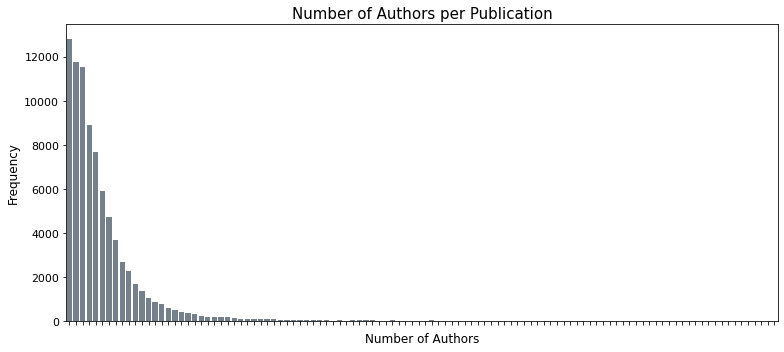

In [44]:
data_author_wo_anony = data_author.loc[data_author.AF != '[Anonymous]']
author_per_ppr = data_author_wo_anony.AF.apply(lambda x: len(x))
author_per_ppr_df = author_per_ppr.value_counts().rename_axis('Number of Authors').reset_index(name='Count').sort_values('Number of Authors')

plt.figure(figsize=(11,5))
g=sns.barplot(x=author_per_ppr_df['Number of Authors'],y=author_per_ppr_df['Count'], color='slategrey')
g.set(xticklabels=[])
plt.xlabel('Number of Authors',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Number of Authors per Publication', fontsize=15)
plt.tight_layout()
plt.savefig('author_per_ppr.jpg')
plt.show()

In [45]:
max(author_per_ppr)

705

In [46]:
np.mean(author_per_ppr)

5.753820054676821

In [47]:
np.median(author_per_ppr)

4.0

# By month

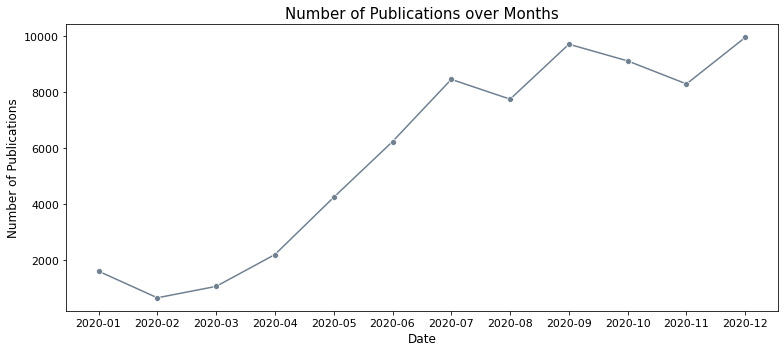

In [48]:
date_count = data_w_date.sort_values(by = 'PD').groupby('PD').size().rename_axis('Date').reset_index(name='Count')
plt.figure(figsize=(11,5))
g=sns.lineplot(x=date_count.Date, y=date_count.Count, color='slategrey', marker='o')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Number of Publications over Months', fontsize=15)
plt.tight_layout()
plt.savefig('date_count.jpg')
plt.show()

# By country over month

In [49]:
country_month = data_w_date[['C1', 'PD']].dropna()
country_month.C1 = country_month.C1.apply(lambda x: re.sub(r"\[(.*?)\]", "", x).split('; ')).to_list()
country_month['country']=[list(set(i)) for i in [[j.split(', ')[-1] for j in i] for i in country_month.C1]]     
country_month['replace'] = [[replace(i) for i in j] for j in country_month['country']]
country_month['replace'] = [list(set(i)) for i in country_month['replace']]                                                 
country_month_all = country_month.explode('replace').drop(columns=['C1','country'])
country_month_all['num']=1
country_month_10 = country_month_all[country_month_all['replace'].isin(data_country_10['Countries'].to_list())].groupby(['PD','replace']).count().reset_index()


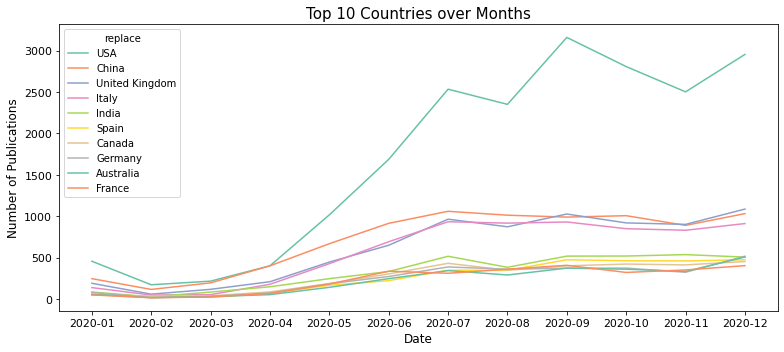

In [50]:

plt.figure(figsize=(11,5))
sns.lineplot(x=country_month_10['PD'], y=country_month_10['num'], hue=country_month_10['replace'],
            hue_order=data_country_10.Countries.to_list(),
            palette='Set2')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Top 10 Countries over Months', fontsize=15)
plt.tight_layout()
plt.savefig('country_month_10.jpg')
plt.show()


# Source over month

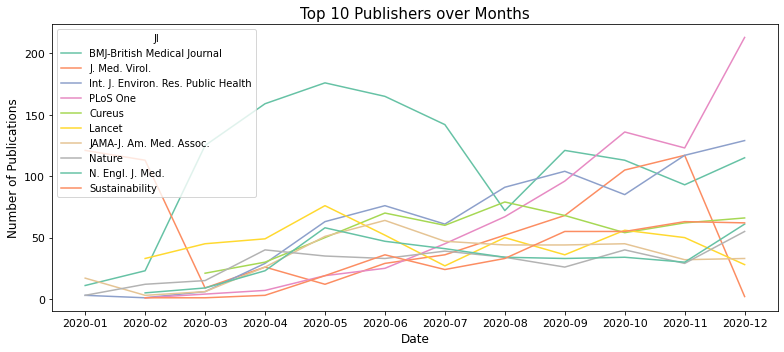

In [51]:
pub_month = data_w_date[['JI', 'PD']].dropna()
pub_month['Number']=1
pub_month_count_10 = pub_month[pub_month['JI'].isin(data_source['Title'].to_list())].groupby(['PD','JI']).count().reset_index()

plt.figure(figsize=(11,5))
sns.lineplot(x=pub_month_count_10['PD'], y=pub_month_count_10['Number'], hue=pub_month_count_10['JI'],
            hue_order=data_source['Title'].to_list(),
            palette='Set2')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Top 10 Publishers over Months', fontsize=15)
plt.tight_layout()
plt.savefig('publisher_month.jpg')
plt.show()

# Research area over month

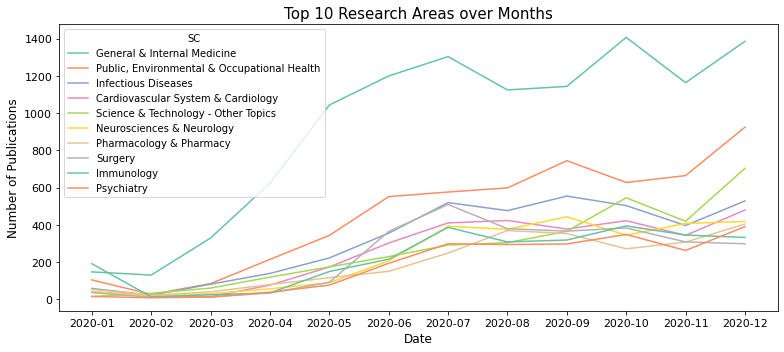

In [52]:
research_month = data_w_date[['SC','PD']].dropna()
research_month['SC'] = research_month['SC'].str.split('; ')
research_month_all = research_month.explode('SC')
research_month_all['num']=1
research_month_10 = research_month_all[research_month_all.SC.isin(data_research_all['ResArea'].to_list())].groupby(['PD','SC']).count().reset_index()

plt.figure(figsize=(11,5))
sns.lineplot(x=research_month_10['PD'], y=research_month_10['num'], 
             hue=research_month_10['SC'],
            hue_order=data_research_all['ResArea'].to_list(),
            palette='Set2')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Top 10 Research Areas over Months', fontsize=15)
plt.tight_layout()
plt.savefig('research_month.jpg')
plt.show()


# Keyword viz

In [53]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [54]:
def get_full_keywords(data_selected):
    data_selected['tok_title'] = [word_tokenize(title) for title in data_selected['TI']]
    data_selected['tok_abstract'] = [word_tokenize(title) for title in data_selected['AB']]
    stop_words=set(stopwords.words("english")+list(string.punctuation)+list(string.digits))
    data_selected['text']=data_selected['tok_title']+data_selected['tok_abstract']
    
    filtered_texts=[]
    for t in data_selected['text']:
        filtered_text=[]
        for word in t:
            if word.lower() not in stop_words:
                filtered_text.append(word)
        filtered_texts.append(filtered_text)

    keywords_text = [[item.lower() for item in sublist] for sublist in filtered_texts]
    kl = [x for sub in keywords_text for x in sub]
    
    keys_dist_20 = Counter(kl)
    return keys_dist_20

In [55]:
cloud = data[['TI','AB']].dropna()
key_freq = get_full_keywords(cloud)

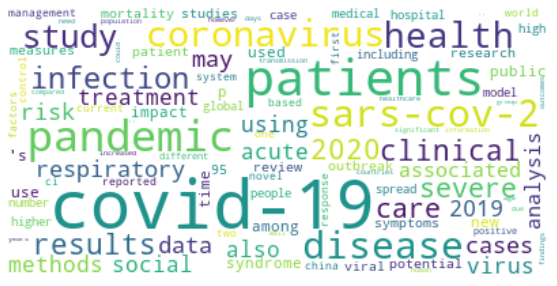

In [56]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(key_freq)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('cloud_all.jpg')
plt.show()

# Corr

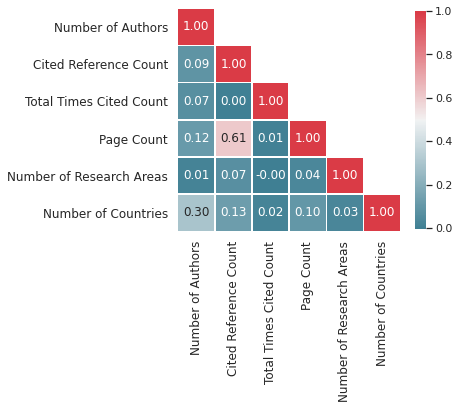

In [57]:
corr_ana = data[['AF', 'NR', 'Z9', 'PG', 'SC', 'C1']].dropna()
corr_ana['Number of Authors']=corr_ana['AF'].str.split(';').apply(lambda x: len(x))
corr_ana['Number of Research Areas']=corr_ana['SC'].str.split(';').apply(lambda x: len(x))
corr_ana['addresses'] = corr_ana['C1'].apply(lambda x: re.sub(r"\[(.*?)\]", "", x).split('; ')).to_list()
country_replace_corr = [[i.replace('North Ireland', 'UK').replace('Wales','UK').replace('Scotland', 'UK').replace('England', 'UK').replace('Czech Republic','Czech') 
for i in x] for x in corr_ana['addresses']]
corr_ana['country_whole']=[list(set(i)) for i in [[j.split()[-1] for j in i] for i in country_replace_corr]]
corr_ana['Number of Countries'] = corr_ana['country_whole'].apply(lambda x: len(x))

corr= corr_ana[['Number of Authors', 'NR', 'Z9', 'PG', 'Number of Research Areas', 'Number of Countries']].rename(
    columns={"NR": "Cited Reference Count", "Z9": "Total Times Cited Count", "PG": "Page Count"}).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(5, 5))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, annot=True, fmt = '.2f',
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax )

locs, labels = plt.yticks();
g.set_yticklabels(labels, rotation=0, size='medium')
locs, labels = plt.xticks();
g.set_xticklabels(labels, rotation=90, size='medium')
plt.savefig('corr.jpg')
plt.show()

# h-, g-index

In [58]:
def h_index(li):
    li_sorted=sorted(li, reverse=True)
    for i in li_sorted:
        if i < li_sorted.index(i)+1:
            break
    return li_sorted.index(i)

def g_index(li):
    li_sorted=sorted(li, reverse=True)
    for i in li_sorted:
        if sum(li_sorted[:li_sorted.index(i)+1])<(li_sorted.index(i)+1)**2:
            break
    return li_sorted.index(i)+1

In [59]:
data_author_index = data[['AF', 'Z9']].dropna()
data_author_index = data_author_index.loc[data_author_index.AF != '[Anonymous]']

data_author_index['Authors'] = data_author_index['AF'].str.split('; ')
data_author_index_sep = data_author_index.explode('Authors').reset_index().drop(columns=['index','AF'])
data_author_index_sep=data_author_index_sep[['Authors','Z9' ]]
data_h=data_author_index_sep.groupby('Authors').agg(lambda x: list(x)).reset_index()
data_h['h_index']= data_h['Z9'].apply(h_index)
h_index_top10 = data_h.sort_values('h_index',ascending=False).drop(columns='Z9').reset_index(drop=True).head(20)
data_h['g_index']= data_h['Z9'].apply(g_index)
g_index_top10 = data_h.sort_values(['h_index','g_index'],ascending=False).drop(columns='Z9').reset_index(drop=True).head(20)
g_index_top10

,Authors,h_index,g_index
0,"Lippi, Giuseppe",26,62
1,"Liu, Lei",26,50
2,"Drosten, Christian",23,38
3,"Baric, Ralph S.",21,47
4,"Wang, Wei",20,56
5,"Zhang, Wei",19,49
6,"Yuen, Kwok-Yung",18,46
7,"Yang, Yang",18,37
8,"Rodriguez-Morales, Alfonso J.",18,36
9,"Wang, Ying",17,51


# Deg of collab

In [60]:
colab_month_w_anonymous = data_w_date[['PD', 'AF']].dropna()
colab_month = colab_month_w_anonymous.loc[colab_month_w_anonymous['AF'] !='[Anonymous]'].copy()
colab_month[['AF']]=colab_month[['AF']].applymap(list)
colab_month['AF'] = colab_month['AF'].apply(lambda x: ';' in x).astype('int')

colab_month_sep=colab_month.groupby('PD')['AF'].value_counts().rename_axis(['Date','sin/mul']).reset_index(name='Count')
deg_colab_pivot = colab_month_sep.pivot(index='Date', columns='sin/mul', values='Count').fillna(0).reset_index()
deg_colab_pivot['deg_colab']=deg_colab_pivot[1]/(deg_colab_pivot[0]+deg_colab_pivot[1])
deg_colab_pivot

sin/mul,Date,0,1,deg_colab
0,2020-01,223,1376,0.860538
1,2020-02,117,526,0.818040
2,2020-03,324,712,0.687259
3,2020-04,575,1527,0.726451
4,2020-05,1043,3073,0.746599
5,2020-06,1117,5004,0.817513
6,2020-07,1373,6948,0.834996
7,2020-08,1052,6619,0.862860
8,2020-09,1443,8186,0.850140
9,2020-10,1115,7911,0.876468


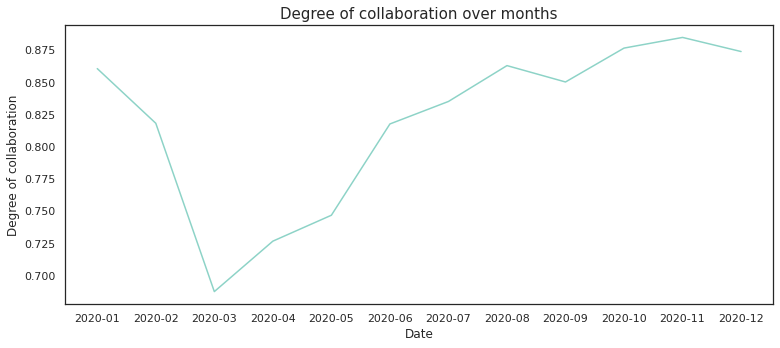

In [61]:
with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
    plt.figure(figsize=(11,5))
    sns.lineplot(x=deg_colab_pivot['Date'], y=deg_colab_pivot['deg_colab'],
            #hue_order=deg_colab_pivot.sort_values(by=['Date'])['Funding'].tolist(),
            palette='Set2')

    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Degree of collaboration',fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.title('Degree of collaboration over months', fontsize=15)
    plt.tight_layout()
    plt.savefig('deg_colab.jpg')
    plt.show()

# International collab & Research area

In [62]:
int_colab = data_w_date[['PD','C1']].dropna()
int_colab['C1'] = int_colab['C1'].apply(lambda x: re.sub(r"\[(.*?)\]", "", x).split('; ')).to_list()
int_colab['country_whole']=[list(set(i)) for i in [[j.split(', ')[-1] for j in i] for i in int_colab['C1']]]
int_colab['replace'] = [[replace(i) for i in j] for j in int_colab['country_whole']]
int_colab['replace'] = [list(set(i)) for i in int_colab['replace']]
int_colab['num_country'] = int_colab['replace'].apply(lambda x: len(x))
int_colab.loc[int_colab['num_country']>1, 'num_country'] = 2
int_colab_counts = int_colab.groupby('PD')['num_country'].value_counts().rename_axis(['date','collab']).reset_index(name='Count').pivot(index='date', columns='collab', values='Count').fillna(0).reset_index()
int_colab_counts['percentage_inter_colab']=int_colab_counts[2]/(int_colab_counts[1]+int_colab_counts[2])
int_colab_counts


collab,date,1,2,percentage_inter_colab
0,2020-01,1231,332,0.212412
1,2020-02,460,125,0.213675
2,2020-03,620,224,0.265403
3,2020-04,1388,422,0.233149
4,2020-05,2843,874,0.235136
5,2020-06,4441,1325,0.229795
6,2020-07,6146,1754,0.222025
7,2020-08,5687,1690,0.229090
8,2020-09,7234,1979,0.214805
9,2020-10,6670,1860,0.218054


In [63]:
ra_sm = data_w_date[['PD','SC']].dropna()
ra_sm['SC'] = ra_sm['SC'].str.split(';')
ra_sm['cnt'] = ra_sm['SC'].apply(lambda x: len(x))

ra_sm.loc[ra_sm['cnt']>1, 'cnt'] = 2
ra_sm_counts = ra_sm.groupby('PD')['cnt'].value_counts().rename_axis(['date','ra']).reset_index(name='Count').pivot(index='date', columns='ra', values='Count').fillna(0).reset_index()
ra_sm_counts['percentage_multi_disp']=ra_sm_counts[2]/(ra_sm_counts[1]+ra_sm_counts[2])
ra_sm_counts

ra,date,1,2,percentage_multi_disp
0,2020-01,1047,556,0.346850
1,2020-02,518,138,0.210366
2,2020-03,839,223,0.209981
3,2020-04,1801,397,0.180619
4,2020-05,3204,1035,0.244161
5,2020-06,4597,1628,0.261526
6,2020-07,6098,2347,0.277916
7,2020-08,5393,2346,0.303140
8,2020-09,6777,2922,0.301268
9,2020-10,6318,2785,0.305943


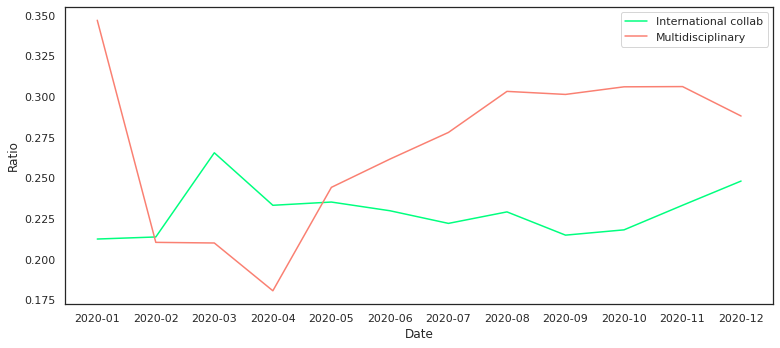

In [64]:
with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
    plt.figure(figsize=(11,5))
    sns.lineplot(x=int_colab_counts['date'], y=int_colab_counts['percentage_inter_colab'], label='International collab', color = 'springgreen')
    sns.lineplot(x=ra_sm_counts['date'], y=ra_sm_counts['percentage_multi_disp'], label='Multidisciplinary', color = 'salmon')
    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Ratio',fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend()
    plt.tight_layout()
    plt.savefig('int_colab_ratio.jpg')
    plt.show()

# Networkx

In [65]:
def to_network(matrix):
    unik=[]
    for i in matrix:
        for j in i:
            unik.append(j)
    keys=list(set(unik))

    dicti={}
    for key in keys:
        value=[]
        for sublist in matrix:
            if key in sublist:
                li = list(sublist)
                li.remove(key)
                value=value+list(set(li))        
        dicti[key]=value
        
    G = nx.Graph()
    for key, value in dicti.items():
        for i in list(value):
            G.add_edge(key, i, weight = value.count(i))       
    return G

In [99]:
matrix_author = list(data_author['AF'])
nw_author = to_network(matrix_author)

In [89]:
matrix_inst = list(data_inst['C1'])
nw_institute = to_network(matrix_inst)

In [67]:
country_mtx_df = list(data_country['replace_1'])
nw_country = to_network(country_mtx_df)

In [73]:
matrix_ra = list(data_research['SC'])
nw_ra = to_network(matrix_ra)

In [81]:
matrix_kwd = [[i.lower() for i in j ]for j in data_keywords.DE]
nw_kwd = to_network(matrix_kwd)

# Centrality author

In [105]:
def centrality(G):
    largest_cc = max(nx.connected_components(G), key=len)
    S = G.subgraph(largest_cc).copy()   
    bet_cen = nx.betweenness_centrality(S)
    pagerank = nx.pagerank(S)
    betweeness = pd.DataFrame(sorted(bet_cen.items(), key=lambda item: item[1], reverse=True), columns=['Name','betweeness']).reset_index(drop=True)
    pgrk = pd.DataFrame(sorted(pagerank.items(), key=lambda item: item[1], reverse=True), columns=['Name','pagerank']).reset_index(drop=True)
    return pd.merge(betweeness,pgrk,on='Name',how='outer').sort_values(by=['betweeness','pagerank'], ascending=False).head(10)

In [ ]:
#centrality_au = centrality(nw_author)
#centrality_au.to_excel('/content/drive/MyDrive/cen_au.xlsx')
#centrality_au


In [100]:
nx.number_connected_components(nw_author)

21223

In [101]:
[len(c) for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)][:10]

[189790, 128, 123, 103, 102, 93, 92, 90, 87, 73]

In [103]:
len(max(nx.connected_components(nw_author), key=len))/len(nw_author)

0.6388063318534775

In [ ]:
#check most important authors belong to what communities

# Centrality institute

In [ ]:
#centrality_inst = centrality(nw_institute)
#centrality_inst.to_excel('/content/drive/MyDrive/cen_inst.xlsx')
#centrality_inst

In [95]:
nx.number_connected_components(nw_institute)

1575

In [96]:
[len(c) for c in sorted(nx.connected_components(nw_institute), key=len, reverse=True)][:10]

[46347, 19, 18, 14, 13, 11, 9, 9, 8, 8]

# Centrality country

In [106]:
centrality_country = centrality(nw_country)
centrality_country.to_excel('/content/drive/MyDrive/cen_cntry.xlsx')
centrality_country

,Name,betweeness,pagerank
0,USA,0.096462,0.115013
1,France,0.050390,0.027912
2,Australia,0.038438,0.027919
3,United Kingdom,0.034480,0.057616
4,Italy,0.025609,0.040281
5,Spain,0.023060,0.026772
6,India,0.022449,0.020990
7,Pakistan,0.021882,0.007888
8,China,0.018578,0.029995
9,Switzerland,0.018540,0.021895


In [97]:
nx.number_connected_components(nw_country)

1

In [98]:
[len(c) for c in sorted(nx.connected_components(nw_country), key=len, reverse=True)]

[196]

# Co-author

In [107]:
co_author = pd.DataFrame(sorted(nw_author.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[:20])
co_author

,0,1,2
0,"Kow, Chia Siang","Hasan, Syed Shahzad",{'weight': 36}
1,"Wiwanitkit, Viroj","Joob, Beuy",{'weight': 35}
2,"Rodriguez-Morales, Alfonso J.","Dhama, Kuldeep",{'weight': 33}
3,"Yuen, Kwok-Yung","Chan, Jasper Fuk-Woo",{'weight': 33}
4,"Tiwari, Ruchi","Dhama, Kuldeep",{'weight': 32}
5,"Yuen, Kwok-Yung","To, Kelvin Kai-Wang",{'weight': 31}
6,"Saussez, Sven","Lechien, Jerome R.",{'weight': 31}
7,"Henry, Brandon Michael","Lippi, Giuseppe",{'weight': 30}
8,"Rodriguez-Morales, Alfonso J.","Sah, Ranjit",{'weight': 29}
9,"Zhao, Shi","He, Daihai",{'weight': 29}


In [108]:
nx.number_of_edges(nw_author)

2644926

In [109]:
nx.number_of_selfloops(nw_author)

162

In [110]:
nx.number_of_nodes(nw_author)

297101

In [111]:
#isolated nodes
len(set([i for j in matrix_author for i in j]))-nx.number_of_nodes(nw_author)

7779

# co-occur institutions


In [90]:
co_institutions = pd.DataFrame(sorted(nw_institute.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[:20])
co_institutions

,0,1,2
0,Huazhong Univ Sci & Technol,Huazhong Univ Sci & Technol,{'weight': 559}
1,Wuhan Univ,Wuhan Univ,{'weight': 372}
2,Univ Toronto,Univ Toronto,{'weight': 342}
3,Harvard Med Sch,Harvard Med Sch,{'weight': 277}
4,Harvard Med Sch,Massachusetts Gen Hosp,{'weight': 243}
5,Univ Tehran Med Sci,Univ Tehran Med Sci,{'weight': 226}
6,Univ Milan,Univ Milan,{'weight': 214}
7,Univ Penn,Univ Penn,{'weight': 209}
8,Columbia Univ,Columbia Univ,{'weight': 207}
9,Harvard Med Sch,Brigham & Womens Hosp,{'weight': 206}


In [91]:
nx.number_of_selfloops(nw_institute)

8006

In [92]:
nx.number_of_edges(nw_institute)

535398

In [93]:
nx.number_of_nodes(nw_institute)

49613

In [94]:
#isolated nodes
len(set([i for j in matrix_inst for i in j]))-nx.number_of_nodes(nw_institute)

2808

# node: country

In [68]:
co_country = pd.DataFrame(sorted(nw_country.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[:20])
co_country

,0,1,2
0,USA,USA,{'weight': 11164}
1,United Kingdom,USA,{'weight': 1620}
2,China,USA,{'weight': 1533}
3,USA,Italy,{'weight': 1187}
4,USA,Canada,{'weight': 1158}
5,United Kingdom,Italy,{'weight': 927}
6,USA,Australia,{'weight': 831}
7,USA,Germany,{'weight': 742}
8,United Kingdom,Australia,{'weight': 684}
9,China,United Kingdom,{'weight': 673}


In [69]:
nx.number_of_selfloops(nw_country)

2

In [70]:
nx.number_of_edges(nw_country)

6404

In [71]:
nx.number_of_nodes(nw_country)

196

In [72]:
len(set([i for j in country_mtx_df for i in j]))-nx.number_of_nodes(nw_country)

5

# co-occurrence of research area

In [74]:
co_occur_ra = pd.DataFrame(sorted(nw_ra.edges(data=True),key= lambda x: x[2]['weight'],reverse=True))[:20]
co_occur_ra

,0,1,2
0,Immunology,Infectious Diseases,{'weight': 948}
1,Infectious Diseases,"Public, Environmental & Occupational Health",{'weight': 919}
2,"Public, Environmental & Occupational Health",Environmental Sciences & Ecology,{'weight': 918}
3,Infectious Diseases,Microbiology,{'weight': 883}
4,Immunology,Microbiology,{'weight': 703}
5,Psychiatry,Psychology,{'weight': 614}
6,Cell Biology,Biochemistry & Molecular Biology,{'weight': 592}
7,General & Internal Medicine,Respiratory System,{'weight': 538}
8,Health Care Sciences & Services,Medical Informatics,{'weight': 461}
9,Cardiovascular System & Cardiology,Hematology,{'weight': 425}


In [75]:
nx.number_of_edges(nw_ra)

1071

In [76]:
nx.number_of_selfloops(nw_ra)

0

In [77]:
nx.number_connected_components(nw_ra)

1

In [78]:
[len(c) for c in sorted(nx.connected_components(nw_ra), key=len, reverse=True)]

[150]

In [79]:
nx.number_of_nodes(nw_ra)

150

In [80]:
#isolated nodes
len(set([i for j in matrix_ra for i in j]))-nx.number_of_nodes(nw_ra)

1

# author keyword co-occurrence

In [82]:
co_occur_key = pd.DataFrame(sorted(nw_kwd.edges(data=True),key= lambda x: x[2]['weight'],reverse=True))[:20]
co_occur_key

,0,1,2
0,covid-19,sars-cov-2,{'weight': 7106}
1,covid-19,coronavirus,{'weight': 4107}
2,covid-19,pandemic,{'weight': 3024}
3,sars-cov-2,coronavirus,{'weight': 1613}
4,pandemic,coronavirus,{'weight': 915}
5,19,covid&#8208,{'weight': 740}
6,covid-19,mental health,{'weight': 686}
7,pandemic,sars-cov-2,{'weight': 671}
8,covid-19,public health,{'weight': 620}
9,covid-19,anxiety,{'weight': 567}


In [83]:
nx.number_of_edges(nw_kwd)

435361

In [84]:
nx.number_of_selfloops(nw_kwd)

206

In [85]:
nx.number_connected_components(nw_kwd)

328

In [86]:
print([len(c) for c in sorted(nx.connected_components(nw_kwd), key=len, reverse=True)])

[61039, 19, 17, 13, 12, 11, 11, 10, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [87]:
nx.number_of_nodes(nw_kwd)

62547

In [88]:
len(set([i for j in matrix_kwd for i in j]))-nx.number_of_nodes(nw_kwd)

18

# small-world

In [112]:
len(max(nx.connected_components(nw_author), key=len))

189790

In [ ]:
largest_cc = max(nx.connected_components(nw_author), key=len)
S = nw_author.subgraph(largest_cc).copy()
nx.average_shortest_path_length(S)

In [114]:
import math
math.log(len(max(nx.connected_components(nw_author), key=len)))

12.153673476730965

# Scale-free

In [115]:
!pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp37-none-any.whl size=24787 sha256=8606374a63e2330d36ba5e975dbfc77787b4487dc68e0edfd9243e81ce9464c4
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [116]:
import powerlaw

In [117]:
degree_sequence = sorted([d for n, d in nw_author.degree()], reverse=True)
len_deg_seq = len(degree_sequence)

In [118]:
fit = powerlaw.Fit(degree_sequence)

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


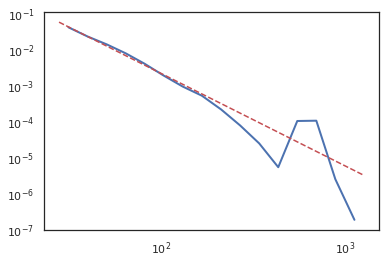

In [119]:
fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig2)

In [120]:
deg_occur = []
for i in degree_sequence:
  num = degree_sequence.count(i)
  deg_occur.append(num)

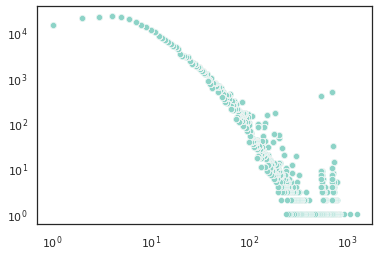

In [121]:
with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
  f, ax = plt.subplots()
  ax.set(xscale="log", yscale="log")
  sns.scatterplot(x=degree_sequence, y=deg_occur, ax=ax)


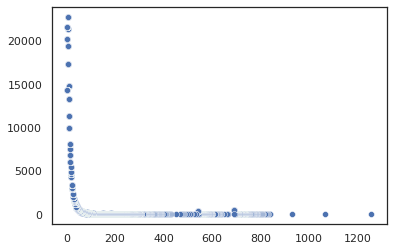

In [122]:
f, ax = plt.subplots()

sns.scatterplot(x=degree_sequence, y=deg_occur)

# assort co-author ntw (double check this section)

In [123]:
sub_nw_author_component = [nw_author.subgraph(c).copy() for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)]
assort_l = []
avg_clustering = []
for k in sub_nw_author_component:
  r = nx.degree_assortativity_coefficient(k)
  clust = nx.average_clustering(k)
  assort_l.append(f"{r:3.1f}")
  avg_clustering.append(clust)

/usr/local/lib/python3.7/dist-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [124]:
assort = [i.replace('nan', '100') for i in assort_l]
assortativity = [float(i) for i in assort]
weight_au_component_norm = [len(c)/len(nw_author) for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)]
weight_au_component = [len(c) for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)]


In [125]:
assort_non_nan = []
weight_au_component_non_nan = []
for i,j in zip(assortativity, weight_au_component):
  if i!=float(100):
    assort_non_nan.append(i)
    weight_au_component_non_nan.append(j)
print(assort_non_nan)

[0.9, 0.3, 0.5, 0.9, -0.1, 0.5, 0.2, 0.7, 0.6, 0.1, 0.4, 0.7, 0.6, 0.3, 0.1, 0.7, 0.0, 0.8, 0.6, -0.2, 0.8, 0.7, 0.2, 0.6, 0.2, -0.0, 0.4, 0.1, 0.7, 0.5, 0.3, -0.0, -0.1, 0.1, -0.1, 0.5, 0.2, 0.4, -0.0, 0.8, 0.6, 0.7, -0.2, 0.2, 0.7, 0.1, -0.1, 0.2, 0.4, 0.1, 0.7, 0.0, -0.1, -0.2, 0.4, 0.2, 0.3, 0.1, -0.1, -0.0, 0.5, -0.2, 0.9, -0.1, 0.9, 0.7, 0.8, 0.4, -0.1, 0.4, -0.2, 0.2, 0.5, 0.1, 0.5, 0.7, 0.6, -0.1, 0.2, 0.4, -0.1, 0.6, 0.6, 0.6, -0.0, -0.2, 0.1, 0.6, 0.5, 0.4, 0.4, 0.2, 0.3, 0.6, 0.1, 0.2, 0.8, 0.1, 0.3, 0.1, 0.3, 0.2, 0.6, -0.1, -0.1, -0.1, -0.1, 0.0, 0.7, 0.1, -0.2, 0.2, 0.4, 0.1, 0.2, -0.0, -0.2, -0.1, 0.1, 0.0, 0.0, 0.6, 0.0, 0.3, 0.6, 0.0, -0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.7, 0.4, 0.3, 0.4, 0.2, 0.6, 0.1, 0.3, 0.1, 0.1, 0.2, -0.2, 0.3, -0.0, 0.0, 0.6, 0.5, -0.0, -0.2, -0.2, 0.2, 0.7, 0.4, -0.2, 0.6, 0.5, 0.1, 0.4, 0.6, -0.0, -0.0, -0.1, 0.6, 0.1, 0.2, 0.5, 0.0, -0.1, -0.0, -0.3, 0.5, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.5, 0.0, 0.0, -0.2, 0.6, 0.1, 0.5, 0.1, -0.2, 0.0, 0.2, -0

In [126]:
print(weight_au_component_non_nan[-11:])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [127]:
print(assort_non_nan[-20:])
#component

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


In [128]:
len(assort_non_nan)

2902

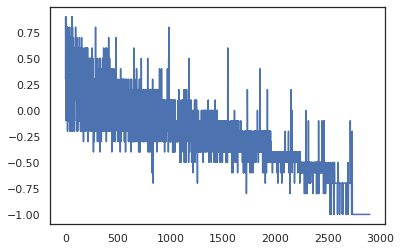

In [129]:
plt.plot(assort_non_nan)

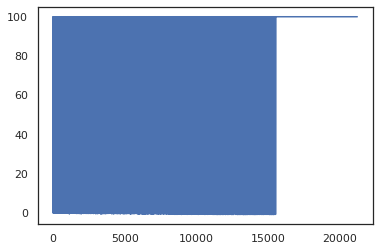

In [130]:
plt.plot(assortativity)
#change 100 to 0 in the above cell

In [131]:
sum(weight_au_component_non_nan)

222172

In [132]:
#removing nan assortativity components. weighted avg
product_1=[]
for i,j in zip(assort_non_nan, weight_au_component_non_nan):
  product_1.append(i*j/sum(weight_au_component_non_nan))
sum(product_1)

0.7567915848981976

In [133]:
sum(assort_non_nan)/len(assort_non_nan)

-0.2814610613370115

# clustering co-au

In [134]:
nx.average_clustering(nw_author)
#this is correct (local)

0.8728849623525544

In [ ]:
from graphviz import Graph

dot = Graph('ER', filename='er.gv', engine='neato')
dot.edge('C2', 'C2')
dot.edge('C3', 'C4')
dot.edge('C3', 'C5')
dot.edge('C5', 'C4')
dot.node('C1')
dot.view()